In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver13.csv")
df2 = pd.read_csv("data/26년FA_야수_ver2.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]
    
    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

# 전처리 적용
df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_5768\554469304.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


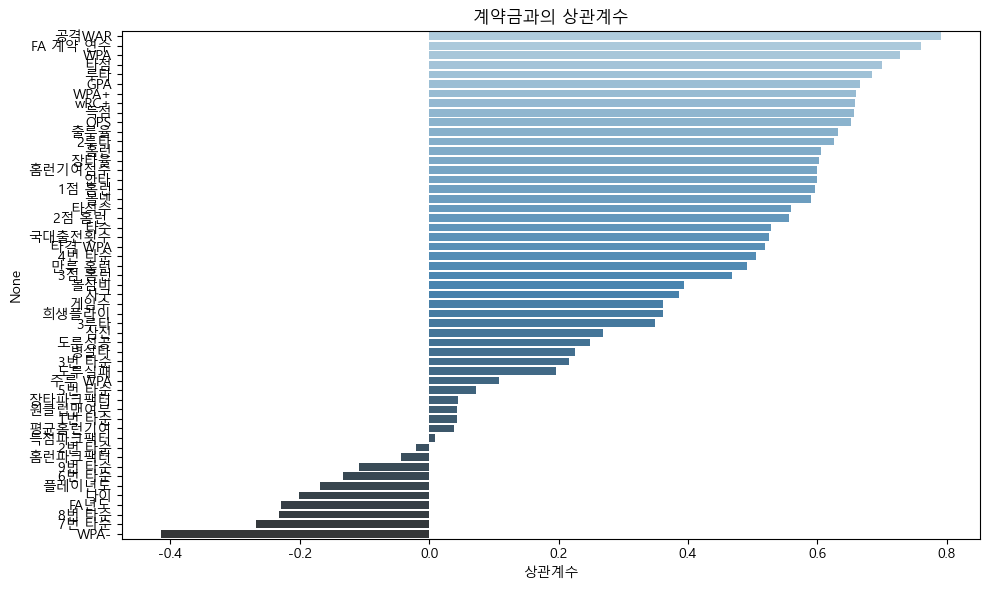

In [5]:
# 상관계수 계산 및 가중치
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 한글 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화: 상관계수
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
print(f"예측에 사용될 공통 피처: {predict_features}")

# 학습/검증/테스트 데이터 준비
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

예측에 사용될 공통 피처: ['공격WAR', 'WPA', '타점', '루타', 'GPA', 'WPA+', 'wRC+', '득점', 'OPS', '출루율', '2루타', '홈런', '장타율', '홈런기여점수', '안타', '1점 홈런', '볼넷', '타석수', '타수', '국대출전횟수', '타격 WPA', '4번 타순', '만루 홈런', '3점 홈런', '볼삼비', '사구', '게임수', '희생플라이', '3루타', '삼진', '도루성공', '병살타', '3번 타순', '도루실패', '주루 WPA', '5번 타순', '장타파크팩터', '원클럽맨여부', '1번 타순', '득점파크팩터', '2번 타순', '홈런파크팩터', '9번 타순', '6번 타순', '플레이년도', '나이', 'FA년도', '8번 타순', '7번 타순', 'WPA-']


In [7]:
# 하이퍼파라미터 튜닝: GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [8]:
# 최적 모델 및 성능 확인
best_model = grid.best_estimator_
val_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, val_pred, squared=False)

print("[RandomForest + GridSearchCV] 최적 파라미터:")
print(grid.best_params_)
print(f"검증 RMSE: {rmse:,.2f}")

# 예측 결과 저장
df2_cleaned['계약금'] = best_model.predict(X_test)

[RandomForest + GridSearchCV] 최적 파라미터:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
검증 RMSE: 134,830.57


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\Lee\AppData\Local\Temp\ipykernel_5768\465971124.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='중요도 (RandomForest)', y='컬럼명', palette='YlOrRd')


피처 중요도 (RandomForest + GridSearchCV):
       컬럼명  중요도 (RandomForest)  상관계수 기반 가중치
0    공격WAR            0.115977     0.037415
1      WPA            0.055885     0.034405
19  국대출전횟수            0.055111     0.024811
7       득점            0.053397     0.031086
2       타점            0.050700     0.033115
5     WPA+            0.047704     0.031188
6     wRC+            0.044953     0.031113
8      OPS            0.042846     0.030850
4      GPA            0.035854     0.031468
10     2루타            0.035077     0.029629
3       루타            0.034548     0.032392
12     장타율            0.027093     0.028517
17     타석수            0.026432     0.026472
20  타격 WPA            0.025778     0.024543
14      안타            0.023819     0.028334
9      출루율            0.018207     0.029911
16      볼넷            0.017421     0.027885
15   1점 홈런            0.014775     0.028206
42   9번 타순            0.014408     0.005094
18      타수            0.013218     0.025004
13  홈런기여점수            0.013096     0.0

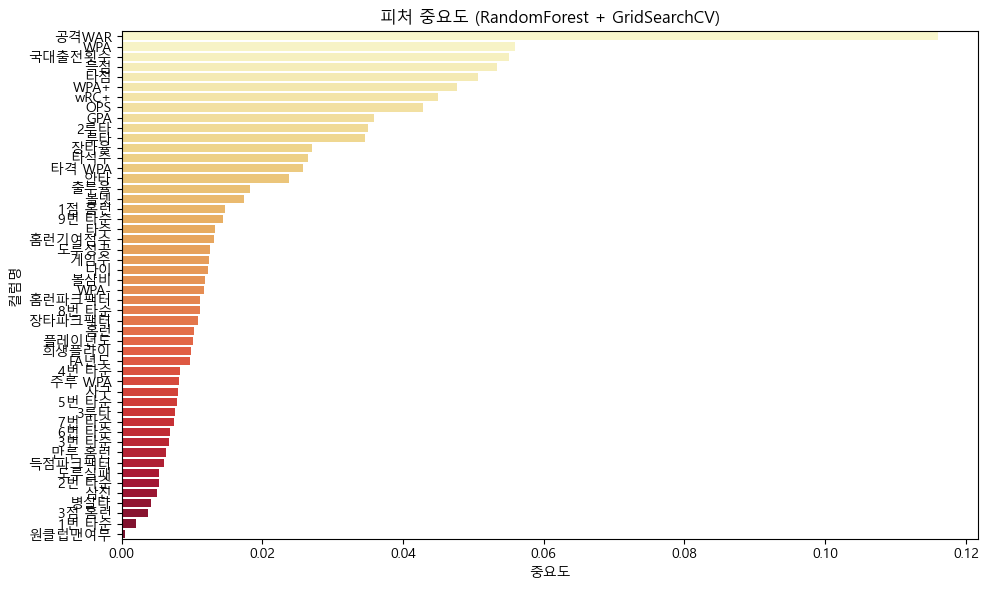

In [9]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (RandomForest)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (RandomForest)', ascending=False)

print("피처 중요도 (RandomForest + GridSearchCV):")
print(importance_df)

# 시각화: 피처 중요도
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='중요도 (RandomForest)', y='컬럼명', palette='YlOrRd')
plt.title('피처 중요도 (RandomForest + GridSearchCV)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [10]:
# 예측 결과 출력
df2_cleaned['계약금'] = df2_cleaned['계약금'].round(0).astype(int)
print("예측 계약금 상위 선수 (RandomForest):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (RandomForest):
    선수명     계약금
0   강민호  199526
1   강백호  100922
2   김재환  190530
3   박병호  173788
4   박승욱   38435
5   박찬호  172241
6   박해민  192193
7   손아섭  154568
8   이재원   44307
9   장성우  161410
10   정훈   43940
11  조수행   39701
12  최원준  140715
13  최형우  231974
14  황재균  137302
